
# **Keras Cats vs Dogs - Training using your own data**

---

In this project we setup data generators to load our own dataset and train a classifier using Keras. 
1. Download and Explore our data
2. Create a simple CNN
3. Create our Data Generators
4. Train our model
5. Test some inferences 
6. Checkpoints

## **1. Download and Loading our Data**

In [ ]:
# import our packages
import os
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

In [ ]:
!pip install --upgrade --no-cache-dir gdown

!gdown --id 1Dvw0UpvItjig0JbnzbTgYKB-ibMrXdxk
!unzip -q dogs-vs-cats.zip
!unzip -q train.zip
!unzip -q test1.zip 

In [ ]:
# Define Image size
IMAGE_HEIGH = 60
IMAGE_WIDTH = 60
IMAGE_CHANNELS = 3

IMAGE_SIZE = (IMAGE_HEIGH, IMAGE_WIDTH)

In [ ]:
filenames = os.listdir("./train")

categories = []

for filename in filenames:
  category = filename.split('.')[0]
  if category == 'cat':
    categories.append(0)
  else:
    categories.append(1)

df = pd.DataFrame({'filename': filenames, 'class': categories})
df.head()

,filename,class
0,dog.3870.jpg,1
1,dog.4663.jpg,1
2,dog.4844.jpg,1
3,cat.5287.jpg,0
4,cat.2499.jpg,0


<AxesSubplot:>

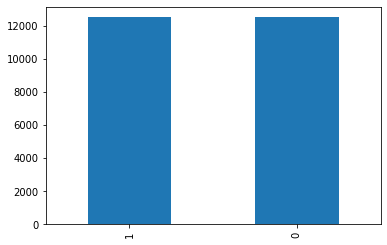

In [ ]:
df['class'].value_counts().plot.bar()

**Lets see one image from our data set**

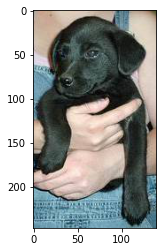

In [ ]:
# View smaple image
sample = random.choice(filenames)
image = load_img("./train/" + sample)
plt.imshow(image)

## **2. Create our model**

In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation

# Create our model
model = Sequential()

model.add(Conv2D(16, (3,3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGH, IMAGE_CHANNELS)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

opt = Adam(learning_rate=0.0005)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 58, 58, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 29, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 5, 64)         0

## **3. Create Our Data Generator**

In [ ]:
df["class"] = df["class"].replace({0: 'cat', 1: 'dog'}) 
df.head()

,filename,class
0,dog.3870.jpg,dog
1,dog.4663.jpg,dog
2,dog.4844.jpg,dog
3,cat.5287.jpg,cat
4,cat.2499.jpg,cat


#### **Split our dataset by using train_test_split**

In [ ]:
# Define train and validation
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=7)

# Drop the index of the tables
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

# Display out train set
train_df.head()

,filename,class
0,dog.1413.jpg,dog
1,dog.3307.jpg,dog
2,cat.6734.jpg,cat
3,cat.5544.jpg,cat
4,cat.3032.jpg,cat


In [ ]:
# Define 32 batch size
batch_size = 32

# Using image data generator to rescale our data
train_datagen = ImageDataGenerator(rescale = 1./255)

# Rescale our data by using flow from data frame method
train_generator = train_datagen.flow_from_dataframe(train_df, 
                                                    "./train/", 
                                                    x_col = 'filename',
                                                    y_col = 'class',
                                                    target_size = IMAGE_SIZE,
                                                    class_mode = 'categorical',
                                                    batch_size = batch_size)

# Using image data generator to rescale our data
validation_datagen = ImageDataGenerator(rescale=1./255)

# Rescale our data by using flow from data fra,e method
validation_generator = validation_datagen.flow_from_dataframe(validate_df, 
                                                              "./train/", 
                                                              x_col='filename',
                                                              y_col='class',
                                                              target_size=IMAGE_SIZE,
                                                              class_mode='categorical',
                                                              batch_size=batch_size)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


#### **Creating an example Data Generator to load just a single image**

Found 1 validated image filenames belonging to 1 classes.


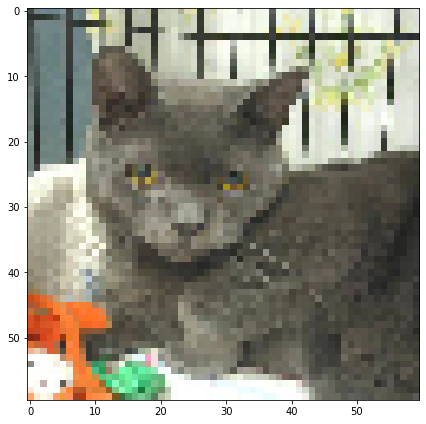

In [ ]:
example_df = train_df.sample(n=1).reset_index(drop=True)

example_generator = train_datagen.flow_from_dataframe(example_df, 
                                                      "./train/", 
                                                      x_col='filename',
                                                      y_col='class',
                                                      target_size=IMAGE_SIZE,
                                                      class_mode='categorical')

# Preview the image
plt.figure(figsize=(6, 6))

for X_batch, Y_batch in example_generator:
    image = X_batch[0]
    plt.imshow(image)
    break

plt.tight_layout()
plt.show()

## **4. Training Our Model**

In [ ]:
import keras.api._v2.keras as keras

from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 1, min_delta = 0.0001)

checkpoint = ModelCheckpoint("Cats_vs_Dogs_Checkpoint.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', # value being monitored for improvement
                          min_delta = 0, #Abs value and is the min change required before we stop
                          patience = 5, #Number of epochs we wait before stopping 
                          verbose = 1,
                          restore_best_weights = True) #keeps the best weigths once stopped

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]

In [ ]:
epochs = 10

history = model.fit(train_generator,
                    epochs = epochs,
                    callbacks = callbacks,
                    validation_data = validation_generator,
                    validation_steps = 5000//batch_size,
                    steps_per_epoch = 20000//batch_size,)

Epoch 1/10
625/625 [==============================] - ETA: 0s - loss: 0.6006 - accuracy: 0.6660
Epoch 1: val_loss improved from inf to 0.53332, saving model to Cats_vs_Dogs_Checkpoint.h5
625/625 [==============================] - 79s 114ms/step - loss: 0.6006 - accuracy: 0.6660 - val_loss: 0.5333 - val_accuracy: 0.7396 - lr: 5.0000e-04
Epoch 2/10
625/625 [==============================] - ETA: 0s - loss: 0.4945 - accuracy: 0.7585
Epoch 2: val_loss improved from 0.53332 to 0.48942, saving model to Cats_vs_Dogs_Checkpoint.h5
625/625 [==============================] - 72s 115ms/step - loss: 0.4945 - accuracy: 0.7585 - val_loss: 0.4894 - val_accuracy: 0.7602 - lr: 5.0000e-04
Epoch 3/10
625/625 [==============================] - ETA: 0s - loss: 0.4366 - accuracy: 0.7982
Epoch 3: val_loss improved from 0.48942 to 0.44744, saving model to Cats_vs_Dogs_Checkpoint.h5
625/625 [==============================] - 75s 120ms/step - loss: 0.4366 - accuracy: 0.7982 - val_loss: 0.4474 - val_accuracy: 0.

In [ ]:
# Save our model
model.save_weights("cats_vs_dogs_10_epochs.h5")

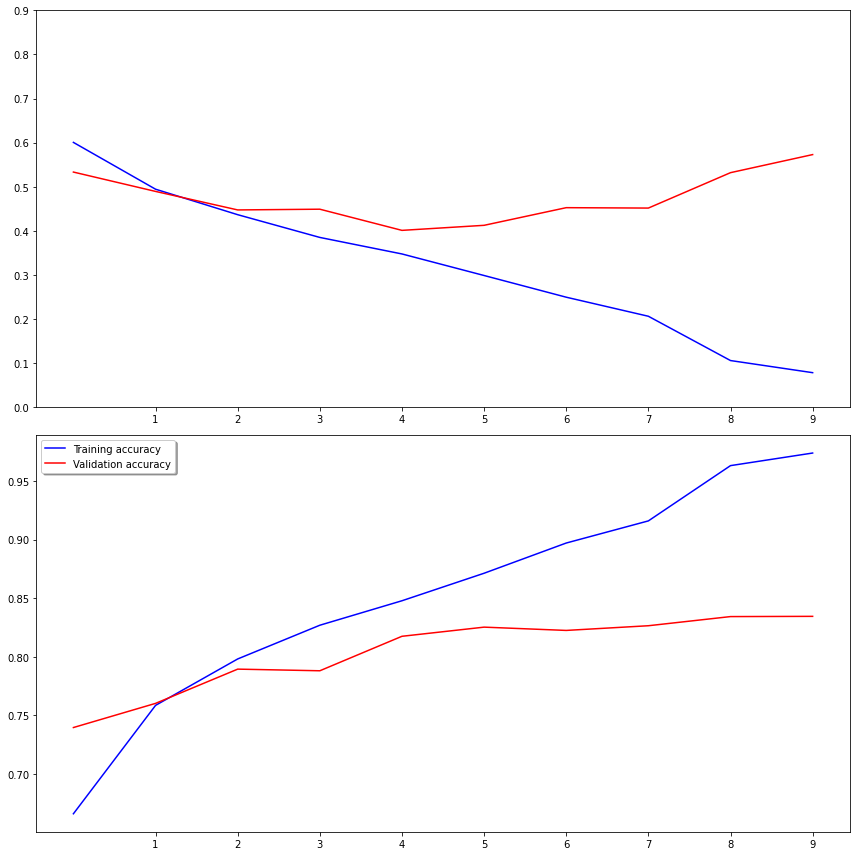

In [ ]:
# Viewour for performance plots

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [ ]:
# We run our prediction on all images in the validation set
predict = model.predict_generator(validation_generator, steps = np.ceil(5000/batch_size))

validate_df['predicted'] = np.argmax(predict, axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
validate_df['predicted'] = validate_df['predicted'].replace(label_map)
validate_df

<ipython-input-17-e23a61eb7775>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(validation_generator, steps = np.ceil(5000/batch_size))


,filename,class,predicted
0,dog.5071.jpg,dog,dog
1,cat.12105.jpg,cat,dog
2,cat.10914.jpg,cat,cat
3,dog.2074.jpg,dog,cat
4,cat.11479.jpg,cat,dog
...,...,...,...
4995,cat.332.jpg,cat,cat
4996,cat.11682.jpg,cat,dog
4997,cat.5160.jpg,cat,cat
4998,dog.7878.jpg,dog,cat


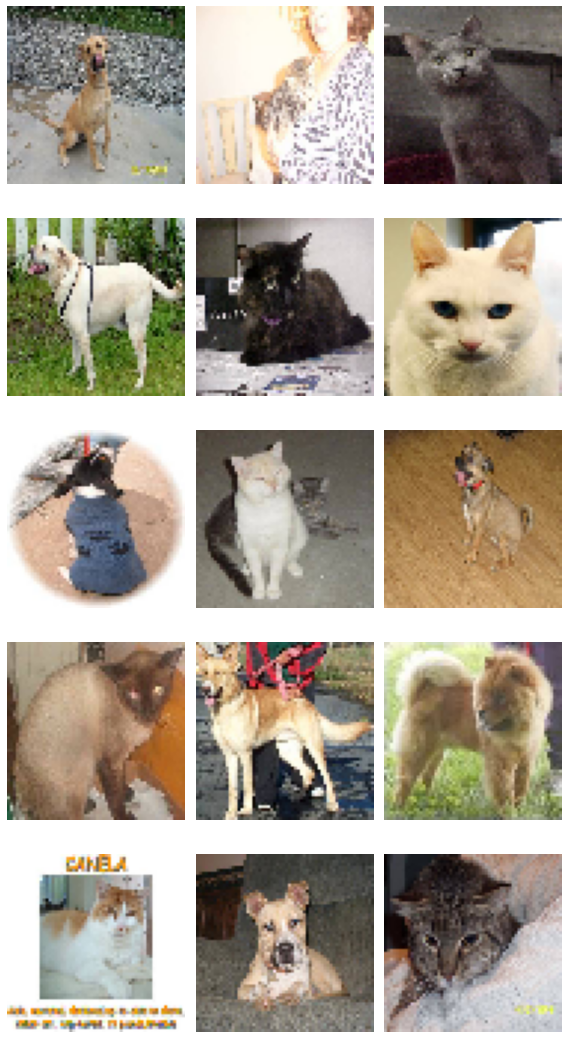

In [ ]:
sample_test = validate_df.head(18)
sample_test.head()

plt.figure(figsize=(8, 15))

for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['predicted']
    img = load_img("./train/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(5, 3, index +1)
    plt.axis('off')
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )

    if index == 14:
      break

plt.tight_layout()
plt.show()